In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cross_validation import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.decomposition import PCA

%matplotlib inline

/home/michael/anaconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
from skimage.measure import regionprops, label
from skimage.filters import threshold_otsu
from skimage.transform import resize, AffineTransform, rotate, warp,SimilarityTransform
from skimage.util import crop

In [4]:
df = pd.read_csv('data/train.csv')

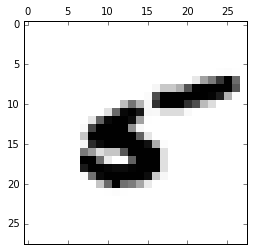

In [8]:
images = df[df.columns[1:]]
given_label = df['label']

#to visualize, reshape it as a 28x28 box
boximages = np.array(images).reshape(42000,28,28)
plt.matshow(boximages[800],cmap=plt.cm.Greys)

# Bounding Box Conceptualize

In [5]:
boximages = np.array(X_test).reshape(len(X_test),28,28)

NameError: name 'X_test' is not defined

In [6]:
image = boximages[800]

In [23]:
thresh = threshold_otsu(image)
image = image > thresh
binary = regionprops(image)[0].image.astype(float)

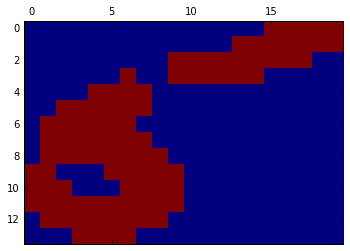

In [24]:
plt.matshow(binary)

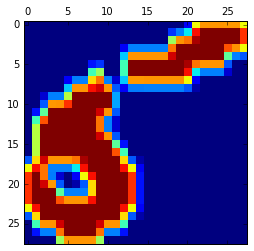

In [25]:
plt.matshow(resize(binary,(28,28)))

# Pre-Processing:
# DESKEW Conceptualizing

In [109]:
binary = np.pad(binary,[[0,5],[5,5]],mode='constant')

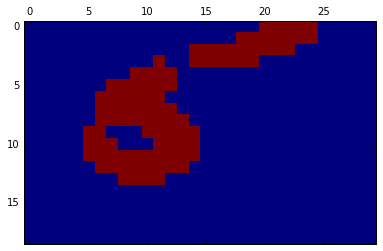

In [110]:
plt.matshow(binary)

In [111]:
thresh = threshold_otsu(binary)
binary = binary > thresh

In [112]:
i, j=np.nonzero(regionprops(binary.astype(int))[0].image)

(28, 0)

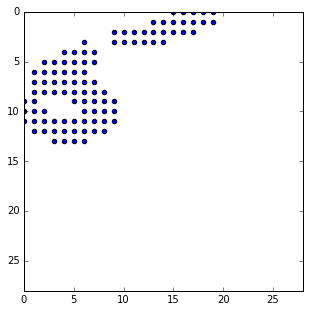

In [113]:
plt.figure(figsize=(5,5))
plt.scatter(j,i)
plt.xlim(0,28)
plt.ylim(28,0)

In [114]:
deskew = PCA()
deskew.fit(np.array([i,j]).T)
theta = np.arccos(np.dot(np.array([1,0]),deskew.components_[0]))
if deskew.components_[0][1] >=0:
    theta *= -1
print np.arccos(np.dot(np.array([1,0]),deskew.components_[1]))
print theta

shears = AffineTransform(shear=theta)

2.52239029457
0.951593967772


In [115]:
print deskew.components_[0]
print deskew.components_[1]

[ 0.58038579 -0.81434166]
[-0.81434166 -0.58038579]


In [116]:
moved = warp(binary.astype(float),shears)

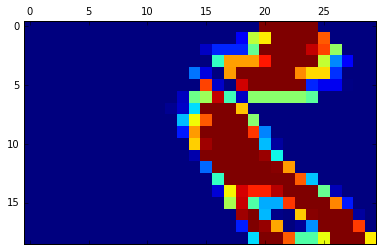

In [117]:
plt.matshow(moved)

# Rotation

In [118]:
rotated = rotate(binary,theta*180/np.pi)

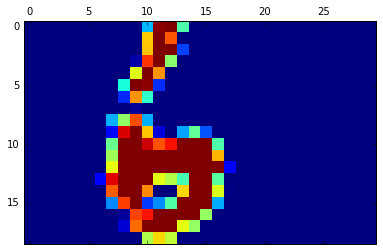

In [119]:
plt.matshow(rotated)

# Pre-processing: All the data!

In [55]:
#Rotate and bounding box
def r_bb(num):
    #Binary, get bounding box
    thresh = threshold_otsu(num)
    binary = num > thresh
    
    bb = regionprops(binary.astype(int))[0].image.astype(float)
    bb_pad = np.pad(bb,[[0,7],[0,7]],mode='constant')
    ## Shear
    i, j=np.nonzero(bb_pad)
    deskew = PCA()
    deskew.fit(np.array([i,j]).T)
    theta = np.arccos(np.dot(np.array([1,0]),deskew.components_[0]))
    
    x_reshape = int(bb.shape[0] * 28./max(bb.shape))
    y_reshape = int(bb.shape[1] * 28./max(bb.shape))
    if x_reshape %2 == 1:
        x_reshape += 1
    if y_reshape %2 == 1:
        y_reshape +=1
    
    bb = resize(bb,(x_reshape,y_reshape))
    
    if theta >= np.pi/4:
        return np.pad(bb,[[(28-bb.shape[0])/2,(28-bb.shape[0])/2],[(28-bb.shape[1])/2,(28-bb.shape[1])/2]],mode='constant')
    if deskew.components_[0][1] >=0:
        theta *= -1
    

#     shears = AffineTransform(shear=theta)
    moved = rotate(bb_pad.astype(float),theta*180/np.pi)
#     moved = warp(bb_pad.astype(float),shears)

    thresh = threshold_otsu(moved)
    moved = moved > thresh
    new_box = regionprops(moved.astype(int))[0].image.astype(float)
    
    x_reshape = int(new_box.shape[0] * 28./max(new_box.shape))
    y_reshape = int(new_box.shape[1] * 28./max(new_box.shape))
    if x_reshape %2 == 1:
        x_reshape += 1
    if y_reshape %2 == 1:
        y_reshape +=1
    
    new_box = resize(new_box,(x_reshape,y_reshape))
    return np.pad(new_box,[[(28-new_box.shape[0])/2,(28-new_box.shape[0])/2],[(28-new_box.shape[1])/2,(28-new_box.shape[1])/2]],mode='constant')
#     return resize(new_box,(28,28))

In [221]:
#Just bounding box
def preprocess(num):
    thresh = threshold_otsu(num)
    binary = num > thresh
    binary = binary.astype(int)
    return resize(regionprops(binary)[0].image.astype(float),(28,28))

#     Use this if you want more than one blob
#     return resize(regionprops(label(binary))[0].image.astype(float),(28,28))

In [ ]:
def blob_count(img):
    

In [160]:
def binarize(matrix):
    new_matrix = np.empty(matrix.shape)
    for i, img in enumerate(matrix):
        print img
        img = img.reshape(28,28)
        thresh = threshold_otsu(img)
        img = img > thresh
        new_matrix[i] = regionprops(img.astype(int))[0].image.astype(float).ravel()
    return new_matrix

Test cases, 3, 800, 10

In [236]:
boxxed = np.empty([42000,28,28])

In [237]:
resized = np.empty([42000,28,28])

In [238]:
for i, pic in enumerate(boximages):
    boxxed[i] = preprocess(pic)

In [239]:
for i, pic in enumerate(boximages):
    resized[i] = r_bb(pic)

In [56]:
flatten = resized.reshape(42000,784)

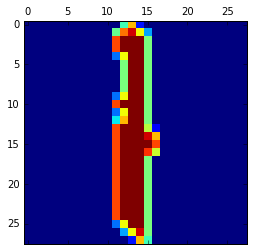

In [57]:
plt.matshow(resized[12])

# Fitting a Model: KNN Grid Search

In [232]:
X_train, X_test, y_train, y_test = train_test_split(flatten,
                                                    given_label,
                                                    test_size = .1,random_state=4444)

In [133]:
param_grid = {'n_neighbors':[2,4,6,8,10]}
grid_search = GridSearchCV(KNeighborsClassifier(),param_grid,verbose=3,cv=5, n_jobs=-1)

In [134]:
grid_search.fit(X_train,y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Done   1 jobs       | elapsed: 11.2min
[Parallel(n_jobs=-1)]: Done  20 out of  25 | elapsed: 33.1min remaining:  8.3min
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed: 37.0min finished


[CV] n_neighbors=2 ...................................................
[CV] n_neighbors=2 ...................................................
[CV] n_neighbors=2 ...................................................
[CV] n_neighbors=2 ...................................................
[CV] n_neighbors=2 ...................................................
[CV] n_neighbors=4 ...................................................
[CV] n_neighbors=4 ...................................................
[CV] n_neighbors=4 ...................................................
[CV] .......................... n_neighbors=2, score=0.944599 -11.2min[CV] .......................... n_neighbors=2, score=0.948691 -11.4min[CV] .......................... n_neighbors=2, score=0.948287 -11.2min[CV] .......................... n_neighbors=2, score=0.946017 -11.1min[CV] .......................... n_neighbors=2, score=0.945606 -11.3min[CV] .......................... n_neighbors=4, score=0.955177 -11.4min[CV] .......

GridSearchCV(cv=5, error_score='raise',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_neighbors=5, p=2, weights='uniform'),
       fit_params={}, iid=True, loss_func=None, n_jobs=-1,
       param_grid={'n_neighbors': [2, 4, 6, 8, 10]},
       pre_dispatch='2*n_jobs', refit=True, score_func=None, scoring=None,
       verbose=3)

In [27]:
import pickle
with open('grid_search.pickle','wb') as handle:
    pickle.dump(grid_search,handle)

In [184]:
grid_search.grid_scores_

[mean: 0.94664, std: 0.00158, params: {'n_neighbors': 2},
 mean: 0.95489, std: 0.00207, params: {'n_neighbors': 4},
 mean: 0.95249, std: 0.00167, params: {'n_neighbors': 6},
 mean: 0.95153, std: 0.00171, params: {'n_neighbors': 8},
 mean: 0.94981, std: 0.00187, params: {'n_neighbors': 10}]

In [29]:
grid_search.best_score_

0.96838624338624335

In [25]:
grid_search.best_params_

{'n_neighbors': 1}

# KNN K = 4 Best Fit

In [59]:
knn = KNeighborsClassifier(n_neighbors = 4,n_jobs=-1)
knn.fit(X_train,y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=4, p=2,
           weights='uniform')

In [60]:
y_fit = knn.predict(X_test)

In [165]:
accuracy_score(y_test,y_fit)

0.97166666666666668

# KNN: Visualizing Averages

In [166]:
average_ones = np.mean(boximages[np.array(given_label==1)], axis=0)

In [167]:
def plot_averages(data,actual):
    fig = plt.figure(figsize = (10,6))
    for i in range(10):
        plt.subplot(2,5,i+1).matshow(np.mean(data[np.array(actual==i)], axis=0),cmap=plt.cm.Greys)
        plt.title('Number: {}'.format(i))
        plt.subplot(2,5,i+1).xaxis.set_ticks_position('bottom')


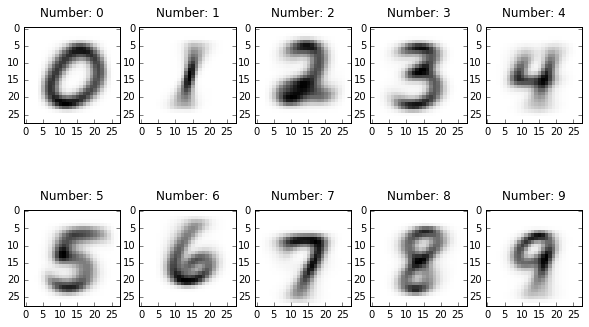

In [263]:
plot_averages(np.array(images).reshape(len(images),28,28),given_label)

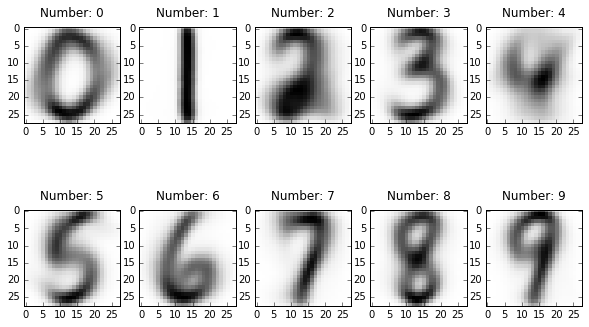

In [168]:
plot_averages(resized,given_label)

# KNN: Visualizing Errors

In [169]:
residual_index = [i for i, (val,valb) in enumerate(zip(y_test,y_fit)) if val!=valb]

In [170]:
residual = [val!=valb for i, (val,valb) in enumerate(zip(y_test,y_fit))]
residual = np.array(residual)
X_images = np.array(X_test).reshape(len(X_test),28,28)
X_residual = X_images[residual]

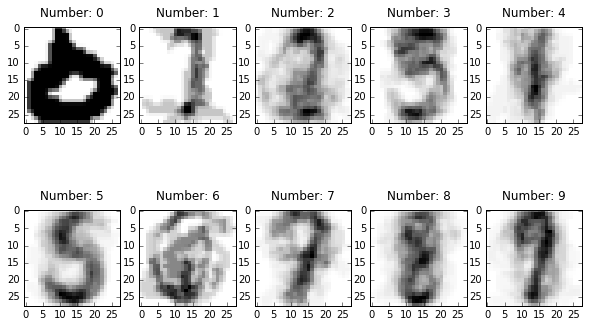

In [171]:
plot_averages(X_residual,y_test[residual])

In [172]:
# plt.matshow(np.mean(X_residual[np.array(y_test[residual]==2)],axis=0),cmap=plt.cm.Greys)

In [173]:
def show_img(i):
    boximages = np.array(X_test).reshape(len(X_test),28,28)
    print 'Actual:', list(y_test)[i]
    print 'Predicted:', list(y_fit)[i]
    plt.matshow(boximages[i],cmap=plt.cm.Greys)

Actual: 5
Predicted: 6


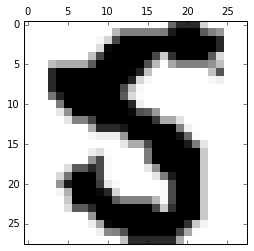

In [175]:
show_img(8)

In [176]:
confusion = np.zeros([10,10])
for i,j in zip(y_test,y_fit):
    confusion[i][j]+=1

In [177]:
print confusion

[[ 431.    0.    0.    0.    0.    0.    1.    0.    0.    0.]
 [   0.  456.    2.    0.    0.    0.    0.    1.    0.    0.]
 [   5.    4.  421.    1.    0.    0.    0.    7.    0.    0.]
 [   0.    0.    1.  451.    0.    6.    0.    2.    1.    1.]
 [   0.    5.    0.    0.  402.    0.    2.    0.    0.    5.]
 [   1.    0.    0.    6.    0.  376.    4.    0.    2.    0.]
 [   3.    0.    0.    0.    0.    1.  371.    0.    0.    0.]
 [   0.    3.    1.    1.    1.    0.    0.  419.    0.    6.]
 [   0.    7.    1.    6.    0.    7.    1.    2.  365.    1.]
 [   1.    2.    1.    2.    5.    1.    0.    7.    2.  389.]]


In [178]:
percentage = confusion/np.sum(confusion, axis=1)

In [179]:
for i in range(10):
    percentage[i][i] = 0

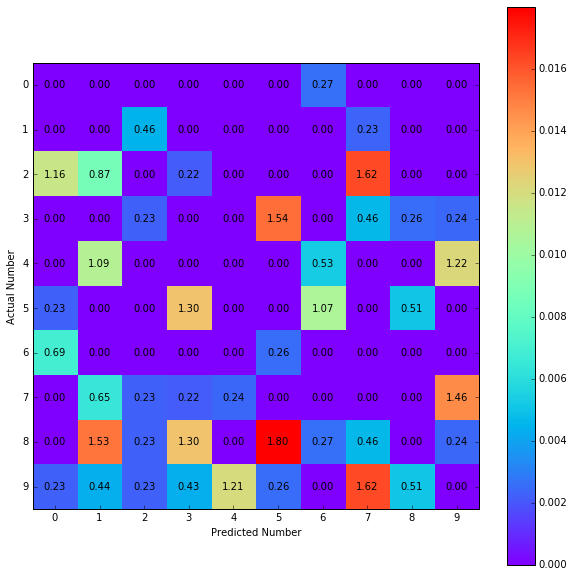

In [180]:
%matplotlib inline

fig, ax = plt.subplots(figsize=(10,10))
# plt.figure()
c = ax.matshow(percentage,cmap=plt.cm.rainbow)
fig.colorbar(c)
plt.xticks(range(10))
plt.yticks(range(10))
plt.xlabel('Predicted Number')
plt.ylabel('Actual Number')

for (i, j), z in np.ndenumerate(percentage):
    ax.text(j, i, '{:0.2f}'.format(z*100), ha='center', va='center')
    ax.xaxis.set_ticks_position('bottom')

In [260]:
print classification_report(y_test,y_fit,digits=5)

             precision    recall  f1-score   support

          0    0.97732   0.99769   0.98740       432
          1    0.95597   0.99346   0.97436       459
          2    0.98595   0.96119   0.97341       438
          3    0.96574   0.97619   0.97094       462
          4    0.98529   0.97101   0.97810       414
          5    0.96164   0.96658   0.96410       389
          6    0.97889   0.98933   0.98408       375
          7    0.95662   0.97216   0.96433       431
          8    0.98649   0.93590   0.96053       390
          9    0.96766   0.94878   0.95813       410

avg / total    0.97187   0.97167   0.97161      4200



# Neural Network

In [187]:
from sklearn.neural_network import BernoulliRBM
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

In [252]:
boxxed = boxxed.reshape(42000,784)

In [273]:
X_train, X_test, y_train, y_test = train_test_split(boxxed,
                                                    given_label,
                                                    test_size = .1,random_state=4444)

In [274]:
logistic = LogisticRegression(n_jobs=-1)

In [275]:
nn_knn = KNeighborsClassifier(n_neighbors = 4, n_jobs = 8)
# nn = BernoulliRBM(random_state=0, verbose=True, learning_rate = .01, n_iter = 20,n_components=500)
nn = BernoulliRBM(random_state=0, verbose=True, learning_rate = .01, n_iter = 10,n_components=500)
nn2 = BernoulliRBM(random_state=0, verbose=True, learning_rate = .001, n_iter = 10,n_components=250)

classifier = Pipeline(steps=[('nn2',nn2),('rbm', nn), ('kneighborsclassifier', knn)])

In [276]:
classifier.fit(X_train,y_train)

[BernoulliRBM] Iteration 1, pseudo-likelihood = -342.17, time = 8.83s
[BernoulliRBM] Iteration 2, pseudo-likelihood = -298.61, time = 9.21s
[BernoulliRBM] Iteration 3, pseudo-likelihood = -276.04, time = 9.13s
[BernoulliRBM] Iteration 4, pseudo-likelihood = -261.17, time = 12.44s
[BernoulliRBM] Iteration 5, pseudo-likelihood = -248.05, time = 11.31s
[BernoulliRBM] Iteration 6, pseudo-likelihood = -238.74, time = 11.27s
[BernoulliRBM] Iteration 7, pseudo-likelihood = -231.47, time = 11.82s
[BernoulliRBM] Iteration 8, pseudo-likelihood = -224.98, time = 12.16s
[BernoulliRBM] Iteration 9, pseudo-likelihood = -219.86, time = 12.87s
[BernoulliRBM] Iteration 10, pseudo-likelihood = -215.59, time = 12.73s
[BernoulliRBM] Iteration 1, pseudo-likelihood = -48.67, time = 6.34s
[BernoulliRBM] Iteration 2, pseudo-likelihood = -42.53, time = 8.20s
[BernoulliRBM] Iteration 3, pseudo-likelihood = -38.69, time = 8.60s
[BernoulliRBM] Iteration 4, pseudo-likelihood = -36.78, time = 7.91s
[BernoulliRBM] I

Pipeline(steps=[('nn2', BernoulliRBM(batch_size=10, learning_rate=0.001, n_components=250, n_iter=10,
       random_state=0, verbose=True)), ('rbm', BernoulliRBM(batch_size=10, learning_rate=0.01, n_components=500, n_iter=10,
       random_state=0, verbose=True)), ('kneighborsclassifier', KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=4, p=2,
           weights='uniform'))])

In [277]:
nn_y = classifier.predict(X_test)

In [278]:
print classification_report(y_test,nn_y,digits=5)

             precision    recall  f1-score   support

          0    0.98624   0.99537   0.99078       432
          1    0.93750   0.98039   0.95847       459
          2    0.97471   0.96804   0.97136       438
          3    0.97155   0.96104   0.96627       462
          4    0.95694   0.96618   0.96154       414
          5    0.95584   0.94602   0.95090       389
          6    0.97638   0.99200   0.98413       375
          7    0.97011   0.97912   0.97460       431
          8    0.97844   0.93077   0.95401       390
          9    0.95274   0.93415   0.94335       410

avg / total    0.96586   0.96571   0.96565      4200



In [267]:
print classification_report(y_test,nn_y,digits=5)

             precision    recall  f1-score   support

          0    0.94855   0.98148   0.96473       432
          1    0.85312   0.92375   0.88703       459
          2    0.90300   0.89269   0.89782       438
          3    0.90244   0.88095   0.89157       462
          4    0.75165   0.82609   0.78711       414
          5    0.84536   0.84319   0.84427       389
          6    0.88071   0.92533   0.90247       375
          7    0.89703   0.90951   0.90323       431
          8    0.83954   0.75128   0.79296       390
          9    0.81948   0.69756   0.75362       410

avg / total    0.86527   0.86524   0.86412      4200



In [259]:
print classification_report(y_test,nn_y,digits=5)

             precision    recall  f1-score   support

          0    0.98169   0.99306   0.98734       432
          1    0.94770   0.98693   0.96692       459
          2    0.98848   0.97945   0.98394       438
          3    0.98261   0.97835   0.98048       462
          4    0.97337   0.97101   0.97219       414
          5    0.97895   0.95630   0.96749       389
          6    0.96867   0.98933   0.97889       375
          7    0.96796   0.98144   0.97465       431
          8    0.98413   0.95385   0.96875       390
          9    0.96500   0.94146   0.95309       410

avg / total    0.97374   0.97357   0.97354      4200



In [215]:
#items=300
print classification_report(y_test,nn_y,digits=5)

             precision    recall  f1-score   support

          0    0.97945   0.99306   0.98621       432
          1    0.97419   0.98693   0.98052       459
          2    0.96110   0.95890   0.96000       438
          3    0.96368   0.97619   0.96989       462
          4    0.95332   0.93720   0.94519       414
          5    0.96477   0.91517   0.93931       389
          6    0.93434   0.98667   0.95979       375
          7    0.94353   0.93039   0.93692       431
          8    0.97403   0.96154   0.96774       390
          9    0.91951   0.91951   0.91951       410

avg / total    0.95722   0.95714   0.95703      4200



In [211]:
#n_items 1000
print classification_report(y_test,nn_y,digits=5)

             precision    recall  f1-score   support

          0    0.96847   0.99537   0.98174       432
          1    0.97624   0.98475   0.98048       459
          2    0.96544   0.95662   0.96101       438
          3    0.96753   0.96753   0.96753       462
          4    0.95500   0.92271   0.93857       414
          5    0.97548   0.92031   0.94709       389
          6    0.94643   0.98933   0.96741       375
          7    0.95991   0.94432   0.95205       431
          8    0.96164   0.96410   0.96287       390
          9    0.90544   0.93415   0.91957       410

avg / total    0.95859   0.95833   0.95826      4200



Logistic has worse performance than KNN.  Higher components higher n_iter better results

# Random Forest

In [38]:
from sklearn.ensemble import RandomForestClassifier

In [44]:
param_grid = {'n_estimators':[8,9,10,11]}
grid_search = GridSearchCV(RandomForestClassifier(),param_grid,verbose=3,cv=5, n_jobs=-1)

In [45]:
grid_search.fit(X_train,y_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Done   1 jobs       | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done   6 out of  20 | elapsed:    5.0s remaining:   11.7s
[Parallel(n_jobs=-1)]: Done  13 out of  20 | elapsed:    9.3s remaining:    5.0s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:   12.5s finished


[CV] n_estimators=8 ..................................................
[CV] n_estimators=8 ..................................................
[CV] n_estimators=8 ..................................................
[CV] n_estimators=8 ..................................................
[CV] n_estimators=8 ..................................................
[CV] n_estimators=9 ..................................................
[CV] n_estimators=9 ..................................................
[CV] n_estimators=9 ..................................................
[CV] ......................... n_estimators=8, score=0.942219 -   4.3s[CV] ......................... n_estimators=8, score=0.942740 -   4.3s[CV] ......................... n_estimators=8, score=0.942071 -   4.3s[CV] ......................... n_estimators=8, score=0.940857 -   4.2s[CV] ......................... n_estimators=8, score=0.944680 -   4.2s[CV] ......................... n_estimators=9, score=0.949094 -   4.8s[CV] .......

GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params={}, iid=True, loss_func=None, n_jobs=-1,
       param_grid={'n_estimators': [8, 9, 10, 11]},
       pre_dispatch='2*n_jobs', refit=True, score_func=None, scoring=None,
       verbose=3)

In [43]:
rfc = RandomForestClassifier()
rfc.fit(X_train,y_train)
rfc.feature_importances_

array([  3.76872353e-05,   1.54387705e-04,   1.27699346e-04,
         1.26985234e-04,   1.96682050e-04,   1.43213255e-04,
         5.18941563e-04,   1.50089995e-04,   2.22586357e-04,
         4.84810513e-04,   1.40332216e-04,   1.85867081e-04,
         4.31477299e-04,   2.28246985e-04,   1.93104664e-03,
         7.06283512e-04,   1.02672563e-03,   2.21420177e-03,
         4.96008828e-04,   3.58277505e-04,   2.52002760e-04,
         4.33667380e-04,   4.43936695e-04,   3.53099460e-04,
         2.03054588e-04,   4.44415580e-04,   1.98609553e-03,
         8.27707586e-04,   3.21585956e-04,   3.10126079e-04,
         2.85771924e-04,   3.01792383e-04,   5.58308395e-04,
         2.84673515e-04,   7.11959575e-04,   4.66900877e-04,
         7.39361062e-04,   9.04279567e-04,   6.56382688e-04,
         9.74832693e-04,   2.60212375e-03,   9.71419174e-04,
         6.80508335e-04,   5.95452024e-04,   2.11011011e-03,
         1.06371209e-03,   3.03945964e-03,   1.16858231e-03,
         6.82645201e-04,

# Naive Bayes

In [136]:
from sklearn.naive_bayes import MultinomialNB

In [143]:
multi_nb = MultinomialNB()

In [144]:
multi_nb.fit(X_train,y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [145]:
multi_y = multi_nb.predict(X_test)

In [146]:
print classification_report(y_test,multi_y,digits=5)

             precision    recall  f1-score   support

          0    0.94676   0.94676   0.94676       432
          1    0.55500   0.72549   0.62890       459
          2    0.89663   0.85160   0.87354       438
          3    0.85376   0.85931   0.85653       462
          4    0.78827   0.74638   0.76675       414
          5    0.87926   0.73008   0.79775       389
          6    0.84433   0.85333   0.84881       375
          7    0.90028   0.75406   0.82071       431
          8    0.69697   0.64872   0.67198       390
          9    0.68230   0.78049   0.72810       410

avg / total    0.80369   0.79119   0.79437      4200



In [ ]:
accuracy_score(y_test,y_fit)

# PCA Experiment

PCA Doesn't actually do anything if I leave all the features in.  Using it as a method for feature reduction would likely reduce the accuracy of my predictions since the model loses data.

In [15]:
pca = PCA(n_components = 500)

In [16]:
pca.fit(X_train)

PCA(copy=True, n_components=500, whiten=False)

In [17]:
X_train_pca = pca.transform(X_train)

In [18]:
X_test_pca = pca.transform(X_test)

In [22]:
param_grid = {'n_neighbors':[1,2,3,4,5]}
grid_search = GridSearchCV(KNeighborsClassifier(),param_grid,verbose=3,cv=5, n_jobs=-1)

In [22]:
grid_search.fit(X_train_pca,y_train)

NameError: name 'grid_search' is not defined

In [175]:
knn = KNeighborsClassifier(n_neighbors = 1 )
knn.fit(X_train_pca,y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_neighbors=1, p=2, weights='uniform')

In [176]:
y_fit = knn.predict(X_test_pca)

In [178]:
accuracy_score(y_test,y_fit)

0.97190476190476194

In [117]:
pca_images = X_test_pca.reshape(len(X_test_pca),28,28)

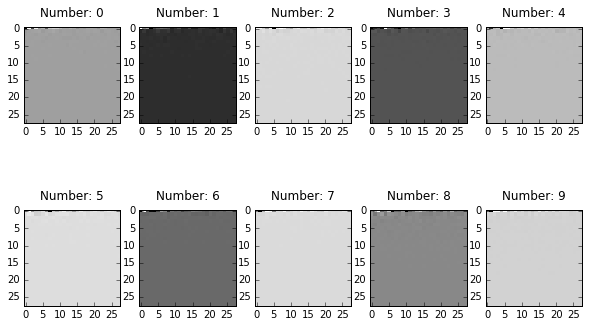

In [118]:
plot_averages(pca_images,y_test)

# Centering Calculations

In [ ]:
3<<2

In [ ]:
indices = np.arange(28)
X, Y = np.meshgrid(indices, indices)

In [ ]:
test = np.array(images)[0]

In [ ]:
np.sum(test.reshape(28,28) *X)/np.sum(test)

In [ ]:
np.sum(test.reshape(28,28) *Y)/np.sum(test)